# 📈 SquidStock Project 1: Temporal CPUE Analysis (The Navigation Course)

**Goal**: Conduct exploratory analysis of raw squid catch (CPUE) and associated environmental variables from 2000–2020 to uncover key temporal trends and variability.

> This notebook is part of the *SquidStock* suite focused on sustainable fisheries research.  
It serves as the **first step in the analysis pipeline**, aimed at understanding the structure, distribution, and temporal dynamics of the raw dataset before applying statistical models.

---

### 🎯 What this notebook covers:
- Visual exploration of **monthly and yearly CPUE trends**
- Seasonal peaks and variability in catch effort
- Distribution of **raw vs. transformed CPUE**
- Summary statistics and trends for key **environmental drivers** (e.g., temperature, depth, chlorophyll-a)
- Temporal patterns and **trend directions** (↑ ↓ →) for selected features
- Hypothesis-forming insights to guide **future modeling** or **hypothesis testing**


---

**Key Outputs**:
- Monthly CPUE plot (interactive + static)
- Table of yearly feature trends with arrow indicators
- Exported visual and tabular summaries

In [1]:

# Import libraries
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import os

In [2]:
# Load dataset
df = pd.read_csv("../data/Final_dataset.csv")
df.columns = df.columns.str.strip()  # Clean column names

In [3]:

# Rename and create datetime
df.rename(columns={"Year1": "Year"}, inplace=True)
df["Date"] = pd.to_datetime(df[["Year", "Month", "Day"]])

In [4]:

# Compute CPUE (Catch Per Unit Effort)
df["CPUE"] = df["SqCatch_Kg"]  # 1 day = 1 effort unit

## 📊 Monthly CPUE Trends

Here we aggregate squid catch by month and year, calculate CPUE (kg/day), and visualize trends across years.

In [ ]:
# ============================
# Monthly CPUE by Year (Aggregation)
# ============================

# Group by Year-Month
monthly_cpue = (
    df.groupby(["Year", "Month"])
    .agg(
        TotalCatch=("CPUE", "sum"),
        DaysFished=("Day", "count")
    )
    .reset_index()
)

monthly_cpue["Monthly_CPUE"] = monthly_cpue["TotalCatch"] / monthly_cpue["DaysFished"]
monthly_cpue.sort_values(["Year", "Month"], inplace=True)

# Export summary
summary = monthly_cpue.groupby("Year")["Monthly_CPUE"].describe()
summary.to_csv("../results/summaries/yearly_cpue_summary.csv")


### 📈 Monthly CPUE by Year

Below we plot monthly CPUE across years to examine seasonal and interannual variation. 
- **Interactive** plot allows hovering and zoom
- **Static PDF** is exported for reproducibility

In [ ]:
# ============================
# Monthly CPUE by Year (Interactive)
# ============================

# Interactive Plot
fig = px.line(
    monthly_cpue,
    x="Month",
    y="Monthly_CPUE",
    color="Year",
    markers=True,
    title="Monthly Standardized CPUE (kg/day) by Year",
    labels={"Monthly_CPUE": "CPUE (kg/day)", "Month": "Month"}
)

fig.update_layout(
    legend_title="Year",
    xaxis=dict(tickmode='linear', tick0=1, dtick=1),
    hovermode='x unified',
    width=900,
    height=600
)

fig.write_html("../results/plots/monthly_cpue_plot.html")
fig.show()


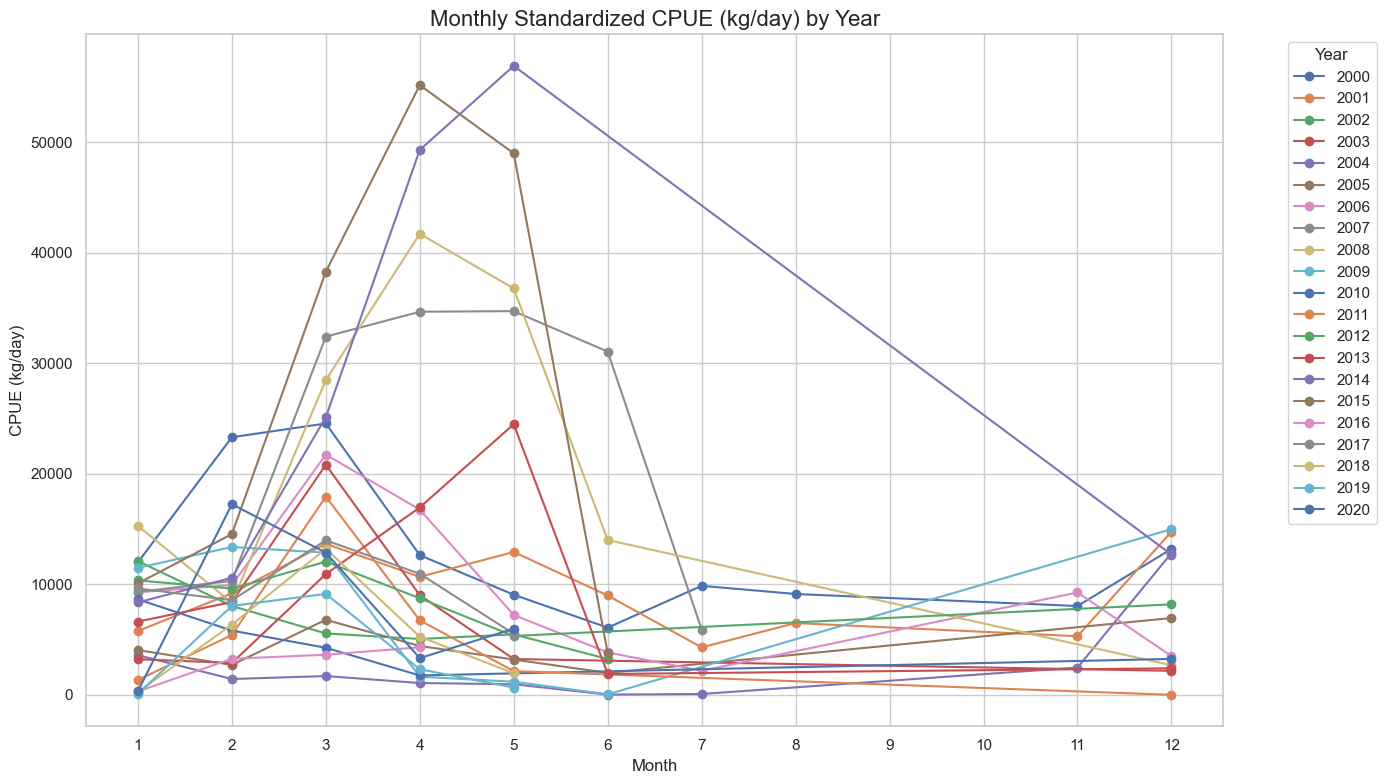

In [ ]:

# ============================
# Monthly CPUE by Year (Static)
# ============================

# Static Plot
sns.set(style="whitegrid")
plt.figure(figsize=(14, 8))

for year in monthly_cpue["Year"].unique():
    data = monthly_cpue[monthly_cpue["Year"] == year]
    plt.plot(data["Month"], data["Monthly_CPUE"], label=year, marker="o")

plt.title("Monthly Standardized CPUE (kg/day) by Year", fontsize=16)
plt.xlabel("Month")
plt.ylabel("CPUE (kg/day)")
plt.xticks(range(1, 13))
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("../outputs/yearly_feature_summary.png", dpi=300, bbox_inches='tight')
plt.show()


## Monthly CPUE Patterns by Year

Monthly trends in standardized CPUE reveal **consistent seasonal timing** but **variable catch intensity**:

- **📆 Seasonal Peak (Mar–May):** Most years show clear CPUE peaks in spring, aligning with known migration and spawning periods.

- **📉 Declining Peak Intensity:** Post-2015, peak CPUE values **drop notably**, despite similar seasonal timing — indicating fewer or less accessible squid.

- **🧭 Biological Consistency:** The persistent seasonal structure confirms a **biological driver** of catch timing, not effort alone.

---

## 🌡️ Yearly Environmental Feature Trends

The table below summarizes mean, standard deviation, and min/max of environmental drivers (e.g., water temperature, SSH, depth, chlorophyll) across years.  
Arrows indicate **year-over-year trends** for each feature.

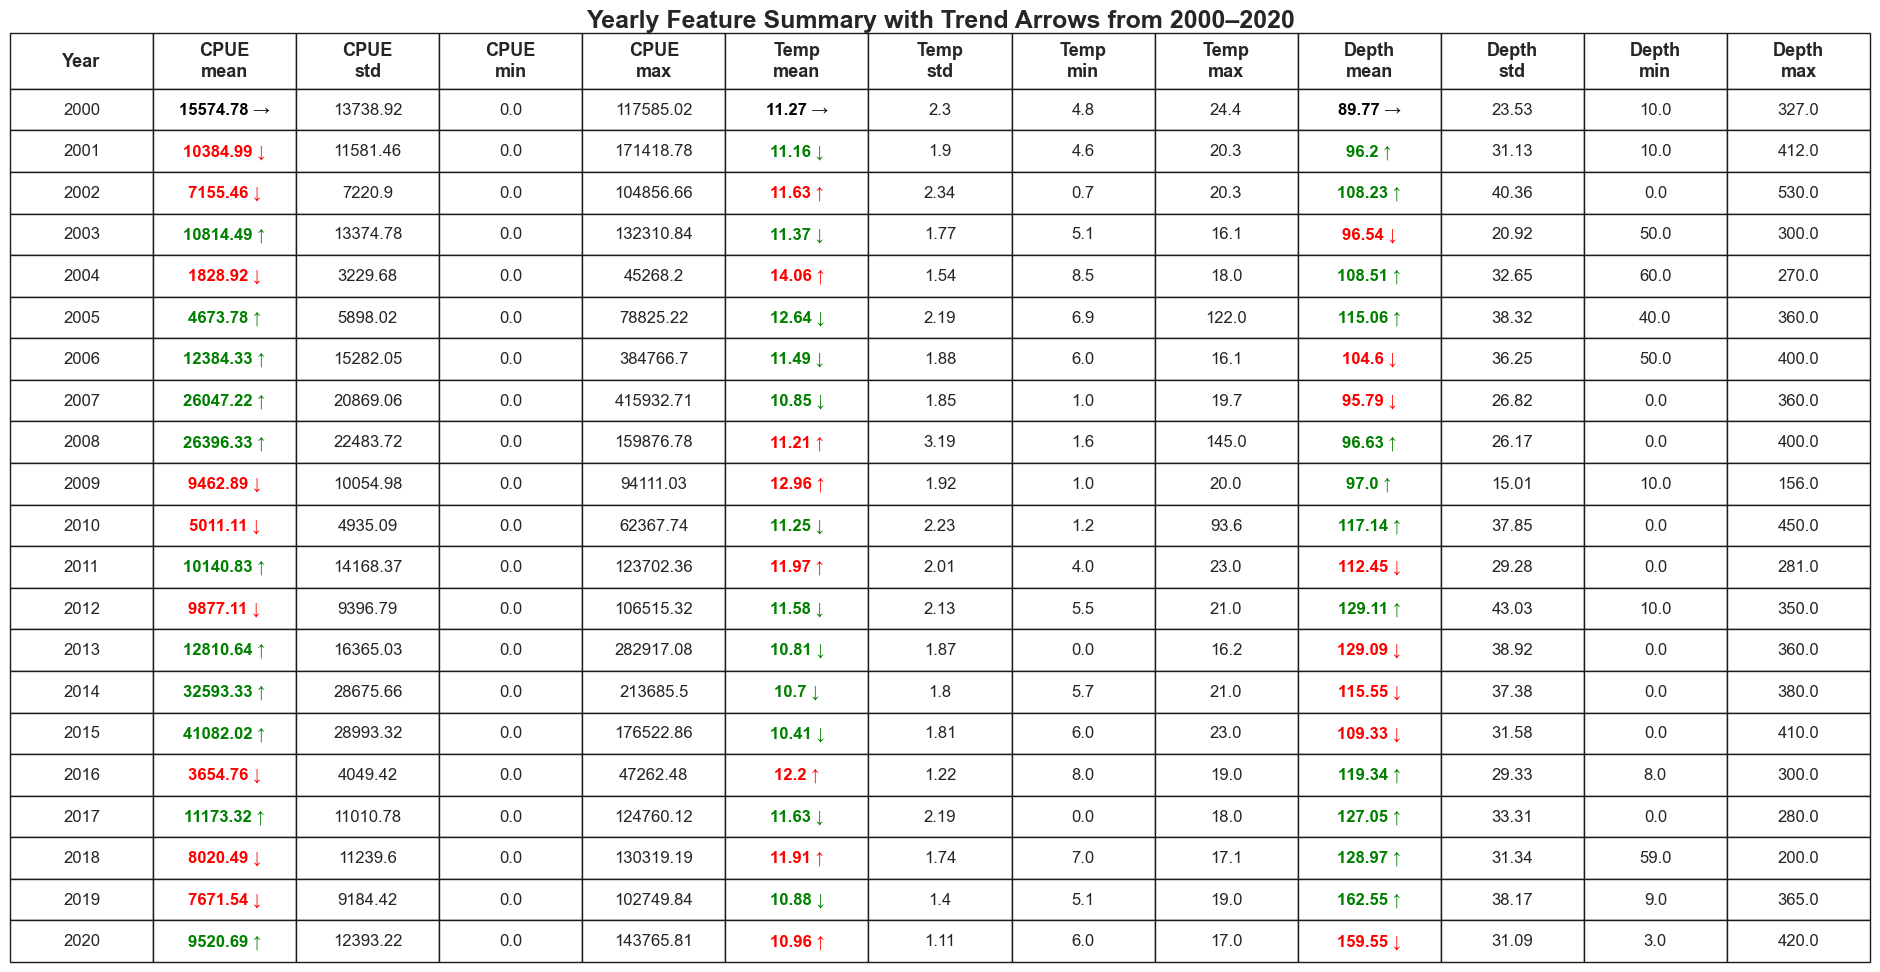

In [10]:
# ============================
# Yearly Feature Summary
# ============================

# --- Step 1: Compute grouped statistics ---
cols_to_agg = ['CPUE', 'WaterTemp', 'Depth']
grouped_stats = df.groupby('Year')[cols_to_agg].agg(['mean', 'std', 'min', 'max'])
grouped_stats = grouped_stats.round(2)
grouped_stats.columns = ['_'.join(col).strip() for col in grouped_stats.columns.values]
grouped_stats.reset_index(inplace=True)

# --- Step 2: Add trend arrows to mean columns ---
numeric_features = ['CPUE', 'WaterTemp', 'Depth']
for feature in numeric_features:
    col = f"{feature}_mean"
    arrows = ['→']
    for i in range(1, len(grouped_stats)):
        prev = grouped_stats.loc[i - 1, col]
        curr = grouped_stats.loc[i, col]
        if curr > prev:
            arrows.append('↑')
        elif curr < prev:
            arrows.append('↓')
        else:
            arrows.append('→')
    grouped_stats[col] = grouped_stats[col].round(3).astype(str) + " " + arrows

# --- Step 3: Round other stats consistently ---
for feature in numeric_features:
    for stat in ['std', 'min', 'max']:
        col = f"{feature}_{stat}"
        if stat == 'std' or (stat == 'mean' and feature == 'SSH'):
            grouped_stats[col] = grouped_stats[col].round(4)
        else:
            grouped_stats[col] = grouped_stats[col].round(3)

# --- Step 4: Custom display names for table column headers ---
display_name_map = {
    'CPUE': 'CPUE',
    'WaterTemp': 'Temp',
    'Depth': 'Depth'
}

def split_colname(name):
    parts = name.split('_', 2)
    if len(parts) == 2:
        feature, stat = parts
    elif len(parts) == 3:
        feature = parts[0] + '_' + parts[1]
        stat = parts[2]
    else:
        return name
    display_feature = display_name_map.get(feature, feature)
    return f"{display_feature}\n{stat}"

stacked_col_labels = [split_colname(col) for col in grouped_stats.columns]

# --- Step 5: Plot the summary table ---
fig, ax = plt.subplots(figsize=(24, 12))
ax.axis('off')
ax.axis('tight')

table = ax.table(
    cellText=grouped_stats.values,
    colLabels=stacked_col_labels,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(12)

for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_text_props(weight='bold', fontsize=13)
        cell.set_height(0.06)
    else:
        cell.set_height(0.045)

plt.title("Yearly Feature Summary with Trend Arrows from 2000–2020", fontsize=18, weight='bold')

# --- Step 6: Color the arrows ---
arrow_color_rules = {
    'WaterTemp':     {'↑': 'red', '↓': 'green', '→': 'black'},
    'SSH':           {'↑': 'red', '↓': 'green', '→': 'black'},
    'CPUE':  {'↑': 'green', '↓': 'red', '→': 'black'},
    'Depth':         {'↑': 'green', '↓': 'red', '→': 'black'},
    'Chlor_a_mg_m3': {'↑': 'green', '↓': 'red', '→': 'black'}
}

for col_idx, col_name in enumerate(grouped_stats.columns):
    for feature, colors in arrow_color_rules.items():
        if col_name == f"{feature}_mean":
            for row_idx in range(1, len(grouped_stats) + 1):  # Skip header
                cell = table[row_idx, col_idx]
                text = cell.get_text().get_text()
                arrow = text[-1]  # Last char is the arrow
                color = colors.get(arrow, 'black')
                cell.get_text().set_color(color)
                cell.get_text().set_fontweight('bold')

# --- Step 7: Save and show ---
plt.savefig("../outputs/yearly_feature_summary.png", dpi=300, bbox_inches='tight')
plt.show()


### 📊 Yearly Environmental Feature Trends (2000–2020)

An analysis of environmental variables over two decades reveals **long-term oceanographic shifts** that closely align with the **observed decline in CPUE**:

- **📉 CPUE Decline:** While interannual peaks exist, mean CPUE generally **declines post-2014**, indicating potential stock stress or environmental displacement.

- **🌡️ Rising Water Temperature:** A steady increase in average water temperature suggests squid may be **migrating to cooler or deeper areas**, reducing their availability to the fleet.

- **⏬ Deepening Fishing Depths:** A clear trend toward deeper average fishing depths supports the hypothesis of **vertical migration** as squid adjust to warming surface layers.

---

🧭 *Next:* The following section will explore how these environmental trends relate to CPUE standardization and predictions, providing possible explanations for observed catch variability.

---

## ✅ Summary

- Monthly CPUE trends highlight seasonal peaks and interannual variability.
- Environmental variables show consistent directional trends over time, potentially linked to biomass changes.
- Visual outputs and tables are exported for further analysis and app integration.

This notebook forms the **exploratory foundation** for modeling and dashboard deployment in later modules.